Please fill in your name and netid (double-click the cell to edit).

Name: Sumanth Rajkumar

netid: ss3657

---
# Convolutional Neural Networks

In this assignment, you will first implement several common filters for image processing using convolution, and then implement the forward and backward pass of a convolution layer that allow the filters to be learned. Finally you will have the opprtunity to freely design your own CNN model for image classification on CIFAR-10.

As in previous assignments, you will see code blocks that look like this:
```python
###############################################################################
# TODO: Create a variable x with value 462.                                   #
###############################################################################
# Replace "pass" statement with your code
pass
# END OF YOUR CODE
```

You should replace the `pass` statement with your own code and leave the blocks intact, like this:
```python
###############################################################################
# TODO: Create a variable x with value 462.                                   #
###############################################################################
# Replace "pass" statement with your code
x = 462
# END OF YOUR CODE
```

Also, please remember:
- Do not write or modify any code outside of code blocks unless otherwise stated.
- Do not delete any cells from the notebook. You may add new cells to perform scratch work, but please delete them before submitting.
- Run all cells before submitting, so that your results are stored in the notebook.
- Submit your notebook as `netid.ipynb`, where `netid` is your actual netid.

In [74]:
from __future__ import print_function
from __future__ import division

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import random_split, DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10

import cv2
import numpy as np
import requests
from io import BytesIO
from PIL import Image

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [75]:
assert torch.cuda.is_available(), 'GPU unavailable'

## Convolution - Filter

[Linear filters](https://en.wikipedia.org/wiki/Kernel_(image_processing)) can be implemented using 2D convolution
- Laplacian Filter (edge detection)
- GaussianBlur (gaussian smoothing)

Instructions: 
- In this part, re-implement filters from OpenCV libarary (cv2) using [`torch.nn.functional.conv2d(input, weight, bias=None, stride=1, padding="same")`](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html). Basically you need to compute the correct convolution weight for each filter and apply it to the input image.
- padding: We use `padding="same"`, meaning the filtered image will have the same size as the original. `padding="same"` is equivalent to setting `padding=(kH//2, kW//2)`. F.conv2d uses zero padding, and we will only consider this mode.
- We will use RGB images which have 3 channels. We will apply the same filter to each channel.  (Hint: treat an RGB image as a batch of 3 images, and use in_channels=out_channels=1.)
- Caveat: 
  - We will denote  $\downarrow$ **vertical direction as H (short for height)**. This is $y$-axis in `cv2`
  - We will denote  $\rightarrow$ **horizontal direction as W (short for width)**. This is $x$-axis in `cv2`
  - e.g., kernel size, kH, kW; blur strength, sigmaH, sigmaW


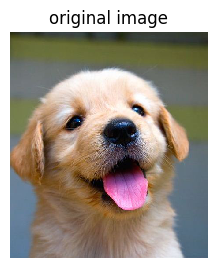

(516, 449, 3)


In [76]:
def error(x, y):
  if type(x) is torch.Tensor:
    x = x.detach().cpu().numpy()
  if type(y) is torch.Tensor:
      y = y.detach().cpu().numpy()    
  return float(np.abs(x - y).max().item())

def display(images, titles=""):
  if type(images) is not list:
    images = [images]
    titles = [titles]
  num = len(images)
  assert len(titles) == num

  plt.figure(figsize=(3*num, 3*num), dpi=100)
  for i in range(num):
    title = titles[i]
    image = images[i]
    plt.subplot(1, num, i+1)
    clip = np.clip(image, 0, 255).astype(np.uint8)
    plt.imshow(clip)
    if len(title) > 0:
      plt.title(title)
    plt.axis('off')
  plt.show()

# read image from url
url = "https://drive.google.com/uc?export=view&id=1IW5HONi0iZoA1gvux_MGXJdnrO8LpJrB"
response = requests.get(url)
rgb_img = Image.open(BytesIO(response.content))
img = np.array(rgb_img).astype("float")
display(img, titles="original image")
print(img.shape)  # H×W×C

### Laplacian Filter (5 points)
- For edge detection 
- A discrete approximation of second-order derivative

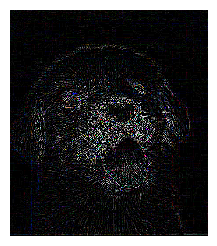

In [77]:
edge = cv2.Laplacian(img.astype(np.uint8), ddepth=24, ksize=1, borderType=cv2.BORDER_CONSTANT)
display(edge * 5)

 **Implement 3×3 Laplacian filter**: equivalent to cv2.Laplacian with ksize=1
- https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gad78703e4c8fe703d479c1860d76429e6
- you shall use `F.conv2d`

In [78]:
def laplacian_filter(img):
  """
  img: np.array of image H × W × C, float
  return: np.array of filterd image H × W × C, float
  """
  filtered = None
  #############################################################################
  # TODO: Implement the Laplacian kernel and apply it to `img` using          #
  # F.conv2d(). The input and output are both numpy arrays. You will need to  #
  # convert between numpy arrays and torch tensors. Pay special attention to  #
  # their shapes. The output values should be limited to [0., 255.].          #
  #############################################################################
  # Replace "pass" statement with your code
  kernel = torch.tensor([[0, 1, 0],
                           [1, -4, 1],
                           [0, 1, 0]], dtype=torch.float32)
  kernel = kernel.repeat(3, 1, 1, 1)
  img_tensor = torch.tensor(img.transpose((2, 0, 1)), dtype=torch.float32)
  filtered_tensor = F.conv2d(img_tensor.unsqueeze(0), kernel, padding=1, groups=3)
  filtered = filtered_tensor.squeeze(0).numpy().transpose((1, 2, 0))
  filtered = np.clip(filtered, 0., 255.).astype(np.float32)
  # END OF YOUR CODE
  return filtered

In [79]:
def check_laplacian_filter(img):
  x = cv2.Laplacian(img.astype(np.uint8), ddepth=24, ksize=1, borderType=cv2.BORDER_CONSTANT)
  y = laplacian_filter(img)
  err = error(x,y)
  assert err < 1e-5, "large error"
  print("pass")

check_laplacian_filter(img)

pass


### Gaussian Blur (15 points)

https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1

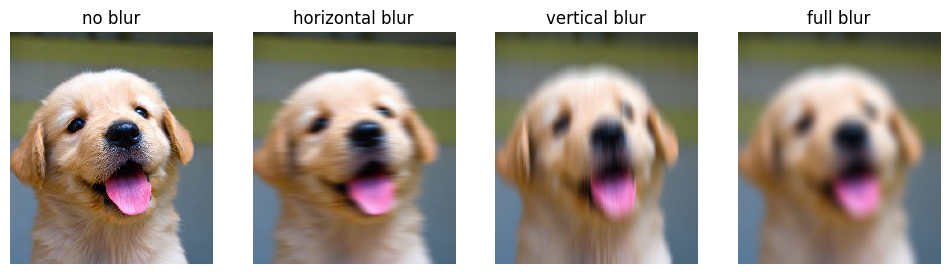

In [80]:
# ksize=(kW, kH)
# if kernel size is 1, no blur in that direction, regardless of sigma
# blur strength increases with kernel size and sigma
no_blur = cv2.GaussianBlur(img, ksize=(1,1), sigmaX=10, sigmaY=20)
h_blur = cv2.GaussianBlur(img, ksize=(31,1), sigmaX=10, sigmaY=20)
v_blur = cv2.GaussianBlur(img, ksize=(1,41), sigmaX=10, sigmaY=20)
full_blur = cv2.GaussianBlur(img, ksize=(31,41), sigmaX=10, sigmaY=20)
display([no_blur, h_blur, v_blur, full_blur], titles=["no blur", "horizontal blur", "vertical blur", "full blur"])

Gaussian Blur is a [separable filter](https://en.wikipedia.org/wiki/Separable_filter), and we will use this property for implementation
- Definition: A 2d filter matrix $\mathbf{H}\in \mathbb{R}^{m\times n}$ is separable iff  it can be factorized as the outer product of two vectors, i.e.,  $\mathbf{H} = \mathbf{y} \mathbf{x}^\top$, where $\mathbf{y}\in\mathbb{R}^m$ and $\mathbf{x}\in\mathbb{R}^n$ 
- $\mathbf{H}$ is separable iff it has rank 1
- Example: box filter, Gaussian filter, Sobel, Prewitt
- Three equivalent implementations (pseudocode):
```python
# a. 2D convolution
Z1 = conv2d(X, H) 
# b. composite 1D convolution, vertical first
Z_y = conv1d(X, y) 
Z2 = conv1d(Z_y, x)
# c. composite 1D convolution, horizontal first
Z_x = conv1d(X, x)
Z3 = conv1d(Z_x, y)
```
- Implement separable filter as composite of 1d convolutions is more [efficient](https://en.wikipedia.org/wiki/Separable_filter) than as a single 2d convolution (especially with relatively large kernel size)


**Implement 1d filter first**
- you shall use [F.conv1d](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html) (similar to conv2d). Roughly, it applies a vector filter to a vector input
- filter weight follows Gaussian distribution. We assume the kernel center is the anchor/origin and the distance is pixel-wise distance from origin: https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gac05a120c1ae92a6060dd0db190a61afa

In [81]:
def gaussian_filter_1d(img, k, sigma, horizontal=True):
  """
  img: np.array of image H × W × C, float
  k: 1d kernel size, positive odd int
  sigma: Gaussian standard deviation, positive float
  horizontal: whether it's horizontal or vertical filter; the function should work for both cases
  return: np.array of filterd image H × W × C, float
  """
  assert k > 0 and k % 2 == 1
  filtered = None
  #############################################################################
  # TODO: Implement the Gaussian kernel and apply it to `img` using           #
  # F.conv1d(). The input and output are both numpy arrays. You will need to  #
  # convert between numpy arrays and torch tensors. Pay special attention to  #
  # their shapes.                                                             #
  #############################################################################
  # Replace "pass" statement with your code
  kernel = np.exp(-np.arange(-k//2+1, k//2+1)**2 / (2*sigma**2))
  kernel /= kernel.sum()

  if horizontal:
      filtered = np.apply_along_axis(lambda m: F.conv1d(torch.tensor(m, dtype=torch.float64).unsqueeze(0).unsqueeze(0), 
                                                                          torch.tensor(kernel, dtype=torch.float64).unsqueeze(0).unsqueeze(0),
                                                                          padding=k//2)[0, 0], axis=1, arr=img)
  else:
      filtered = np.apply_along_axis(lambda m: F.conv1d(torch.tensor(m, dtype=torch.float64).unsqueeze(0).unsqueeze(0), 
                                                                          torch.tensor(kernel, dtype=torch.float64).unsqueeze(0).unsqueeze(0),
                                                                          padding=k//2)[0, 0], axis=0, arr=img)
  # END OF YOUR CODE
  return filtered

In [82]:
def check_gaussian_filter_1d(img, kW, kH, sigmaW=1, sigmaH=1):
  if kH == 1:
    actual = gaussian_filter_1d(img, kW, sigmaW, horizontal=True)
  elif kW == 1:
    actual = gaussian_filter_1d(img, kH, sigmaH, horizontal=False)
  expected = cv2.GaussianBlur(img, ksize=(kW,kH), sigmaX=sigmaW, sigmaY=sigmaH, borderType=cv2.BORDER_CONSTANT)
  assert actual.shape == img.shape
  err = error(actual, expected)
  assert err < 1e-5, f"large error {err: .5f}"
  print(f"pass")

In [83]:
check_gaussian_filter_1d(img, kW=1, kH=1)  # no blur

pass


In [84]:
check_gaussian_filter_1d(img, kW=13, kH=1, sigmaW=10) # horizontal blur

pass


In [85]:
check_gaussian_filter_1d(img, kW=1, kH=17, sigmaH=21) # vertical blur

pass


**Implement 2d gaussian filter**
- you must use the composite of `gaussian_filter_1d` which you implemented above
- you are NOT allowed to use any type of conv2d (such as `F.conv2d`)

In [86]:
def gaussian_filter_2d(img, kW, kH, sigmaW=1, sigmaH=1):
  """
  img: np.array of image H × W × C
  kW: horizontal kernel size, positive odd int
  kH: vertical kernel size, positive odd int
  sigmaW: horizontal sigma, positive float
  sigmaH: vertical sigma, positive float
  return: np.array of filterd image H × W × C, float
  """
  assert kW > 0 and kW % 2 == 1
  assert kH > 0 and kH % 2 == 1
  filtered = None
  #############################################################################
  # TODO: Implement the 2D Gaussian filter by compositing horizontal and      #
  # vertical 1D Gaussian filters (`gaussian_filter_1d`).                      #
  #############################################################################
  # Replace "pass" statement with your code
  
  # Apply gaussian_filter_1d along the horizontal axis
  filtered = gaussian_filter_1d(img, kW, sigmaW, horizontal=True)

  # Apply gaussian_filter_1d along the vertical axis
  filtered = gaussian_filter_1d(filtered, kH, sigmaH, horizontal=False)
  # END OF YOUR CODE
  return filtered

In [87]:
def check_gaussian_filter_2d(img, kW, kH, sigmaW=1, sigmaH=1):
  actual = gaussian_filter_2d(img, kW, kH, sigmaW, sigmaH)
  expected = cv2.GaussianBlur(img, ksize=(kW,kH), sigmaX=sigmaW, sigmaY=sigmaH, borderType=cv2.BORDER_CONSTANT)
  assert actual.shape == img.shape
  err = error(actual, expected)
  assert err < 1e-4, f"large error {err: .4f}"
  print(f"pass")

In [88]:
check_gaussian_filter_2d(img, kW=1, kH=1, sigmaW=50, sigmaH=29)  # no blur

pass


In [89]:
check_gaussian_filter_2d(img, kW=1, kH=13, sigmaW=59, sigmaH=67) # horizontal blur

pass


In [90]:
check_gaussian_filter_2d(img, kW=17, kH=1, sigmaW=59, sigmaH=67) # vertical blur

pass


In [91]:
check_gaussian_filter_2d(img, kW=31, kH=41, sigmaW=59, sigmaH=67) # full blur

pass


In [92]:
check_gaussian_filter_2d(img, kW=21, kH=11, sigmaW=45, sigmaH=30) # full blur

pass


## Convolution - Forward Pass (20 points)

Let us now implement the forward pass of 2D convolution and get a better understanding of the operations it performs. We will be replicating the functionality of PyTorch's built-in 2D convolution: [`nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) and [`F.conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html?highlight=conv2d#torch.nn.functional.conv2d). Please refer to the documentation for more details of the input arguments and return values. It is acceptable to use nested loops here, but you may also develop a vectorized implementation.

In [93]:
def conv2d(input, weight, bias=None, stride=1, padding=0):
  """
  Apply 2D convolution over a batch of input tensors.
  
  Input arguments and return value are the same as those of F.conv2d(),
  except that we don't care about `dilation` and `groups` here.
  Also, `padding_mode` is `zeros`.
  """
  output = None
  
  #############################################################################
  # TODO: Implement the same functionality as F.conv2d(). You are NOT allowed #
  # to use F.conv2d() or nn.Conv2d().                                         #
  #############################################################################
  # Replace "pass" statement with your code
  # Get input tensor shape
  
  batch_size, in_channels, in_height, in_width = input.shape
  out_channels, in_channels, filter_height, filter_width = weight.shape
  
  if isinstance(padding, int):
      padding = (padding, padding)
  if isinstance(stride, int):
      stride = (stride, stride)

  # Calculate output shape
  out_height = int((in_height + 2 * padding[0] - filter_height) / stride[0] + 1)
  out_width = int((in_width + 2 * padding[1] - filter_width) / stride[1] + 1)

  # Add padding to input tensor
  input = F.pad(input, (padding[1], padding[1], padding[0], padding[0]))

  # Initialize output tensor
  output = torch.zeros(batch_size, out_channels, out_height, out_width)

  # Perform 2D convolution
  for b in range(batch_size):
      for c_out in range(out_channels):
          for h_out in range(out_height):
              for w_out in range(out_width):
                  h_in_start = h_out * stride[0]
                  w_in_start = w_out * stride[1]
                  h_in_end = h_in_start + filter_height
                  w_in_end = w_in_start + filter_width
                  sliced_input = input[b, :, h_in_start:h_in_end, w_in_start:w_in_end]
                  output[b, c_out, h_out, w_out] = torch.sum(sliced_input * weight[c_out])  
  if bias is not None:
      output += bias.reshape(1, -1, 1, 1)

  # END OF YOUR CODE
  return output

We will use the following helper functions to check your results:

In [94]:
def max_diff(actual, expected):
  return (actual - expected).abs().max().item()

In [95]:
def check_conv2d(batch_size, in_channels, in_height, in_width,
                 out_channels, kernel_size, stride=1, padding=0, use_bias=True):
  
  if isinstance(kernel_size, int):
    kernel_size = (kernel_size, kernel_size)
  
  torch.manual_seed(0)
  input = torch.empty(batch_size, in_channels, in_height, in_width).normal_()
  weight = torch.empty(out_channels, in_channels, kernel_size[0], kernel_size[1]).normal_()
  if use_bias:
    bias = torch.empty(out_channels).normal_()
  else:
    bias = None
  
  actual = conv2d(input, weight, bias, stride, padding)
  expected = F.conv2d(input, weight, bias, stride, padding)
  assert actual.shape == expected.shape, 'incorrect shape'
  
  diff = max_diff(actual, expected)
  print('max_diff = %e' % diff)
  assert diff < 1e-3, 'incorrect result'

In [96]:
# check `kernel_size`
check_conv2d(batch_size=8, in_channels=3, in_height=8, in_width=8,
             out_channels=8, kernel_size=3, stride=1, padding=0, use_bias=True)

max_diff = 3.814697e-06


In [97]:
# check `stride`
check_conv2d(batch_size=4, in_channels=8, in_height=16, in_width=16,
             out_channels=3, kernel_size=5, stride=3, padding=0, use_bias=True)

max_diff = 1.335144e-05


In [98]:
# check `padding`
check_conv2d(batch_size=1, in_channels=1, in_height=32, in_width=32,
             out_channels=4, kernel_size=8, stride=5, padding=3, use_bias=True)

max_diff = 5.722046e-06


In [99]:
# check tuple arguments
check_conv2d(batch_size=16, in_channels=4, in_height=4, in_width=8,
             out_channels=1, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1), use_bias=False)

max_diff = 9.536743e-07


## Convolution - Backward Pass (Extra Credit: 20 points)

In order to train a CNN, we need to backpropagate the gradient through the convolution. More precisely, suppose we have performed a convolution:
$$
\text{output} = \text{conv2d}(\text{input}, \text{weight}, \text{bias}),
$$
and the loss is defined as some function of the output:
$$
\mathcal{L} = f(\text{output}).
$$
Note that $\text{output}, \text{input}, \text{weight}, \text{bias}$ are tensors, and $\mathcal{L}$ is a scalar.

We need the gradients $\frac{\partial \mathcal{L}}{\partial \text{weight}}$ and $\frac{\partial \mathcal{L}}{\partial \text{bias}}$, which can be computed by the chain rule:
$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial \text{weight}_i} &= \sum_{k} \frac{\partial \mathcal{L}}{\partial \text{output}_k} \frac{\partial \text{output}_k}{\partial \text{weight}_i},\\
\frac{\partial \mathcal{L}}{\partial \text{bias}_j} &= \sum_{k} \frac{\partial \mathcal{L}}{\partial \text{output}_k} \frac{\partial \text{output}_k}{\partial \text{bias}_j}.
\end{align}
$$
If $\text{input}$ is computed by another neural network with parameters $\theta$, then to obtain $\frac{\partial \mathcal{L}}{\partial \theta}$, we also need $\frac{\partial \mathcal{L}}{\partial \text{input}}$.

Therefore, in the backward pass that we will implement below, given $\frac{\partial \mathcal{L}}{\partial \text{output}}$, we need to compute $\frac{\partial \mathcal{L}}{\partial \text{input}}$, $\frac{\partial \mathcal{L}}{\partial \text{weight}}$, and $\frac{\partial \mathcal{L}}{\partial \text{bias}}$.

You are NOT allowed to use PyTorch's automatic differentiation, but you may use other built-in functions (in particular, [`F.conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html?highlight=conv2d#torch.nn.functional.conv2d) and [`F.conv_transpose2d()`](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv_transpose2d.html?highlight=conv_transpose2d#torch.nn.functional.conv_transpose2d)) if they can simplify your implementation.

In [100]:
def conv2d_grad(output_grad, input, weight, bias=None, stride=1, padding=0):
  """
  Backward pass of 2D convolution.
  
  Inputs:
  - output_grad: A PyTorch tensor giving the gradient of loss wrt `output`
    computed by the forward pass conv2d(). It has the same shape as `output`.
  - Other arguments are the same as those of conv2d().
  
  Returns:
  - input_grad: A PyTorch tensor giving the gradient of loss wrt `input`.
    It has the same shape as `input`.
  - weight_grad: A PyTorch tensor giving the gradient of loss wrt `weight`.
    It has the same shape as `weight`.
  - bias_grad: A PyTorch tensor giving the gradient of loss wrt `bias`.
    It has the same shape as `bias` if `bias` is not `None`.
    Otherwise, it is `None`.
  """
  input_grad = None
  weight_grad = None
  bias_grad = None
  #############################################################################
  # TODO: Implement the backward pass of conv2d(). You are NOT allowed to use #
  # PyTorch's automatic differentiation.                                      #
  #############################################################################
  # Replace "pass" statement with your code
  # Get shapes of input tensor, weight tensor, and output gradient tensor
  # Get shapes of input tensor, weight tensor, and output gradient tensor
  # Retrieve dimensions and initialize gradients
  # Get dimensions

  # Retrieve information from inputs and output_grad
  (m, n_C_prev, n_H_prev, n_W_prev) = input.shape
  (n_C, n_C_prev, f, f) = weight.shape
  (m, n_C, n_H, n_W) = output_grad.shape
  (pad_h, pad_w) = padding if type(padding) == tuple else (padding, padding)

  # Initialize gradients
  input_grad = torch.zeros_like(input)
  weight_grad = torch.zeros_like(weight)
  bias_grad = None if bias is None else torch.zeros_like(bias)

  # Pad input_grad and input
  input = F.pad(input, [pad_w, pad_w, pad_h, pad_h], "constant", 0)
  input_grad = F.pad(input_grad, [pad_w, pad_w, pad_h, pad_h], "constant", 0)

  # Compute gradients
  for i in range(m):  # loop over training examples
      for j in range(n_C):  # loop over channels
          for k in range(n_H):  # loop over vertical axis of output volume
              for l in range(n_W):  # loop over horizontal axis of output volume
                  # Find the corners of the current "slice"
                  vert_start = k * stride
                  vert_end = vert_start + f
                  horiz_start = l * stride
                  horiz_end = horiz_start + f

                  # Use the corners to define the slice from padded input
                  sliced_input = input[i, :, vert_start:vert_end, horiz_start:horiz_end]

                  # Update gradients for the window and the filter's parameters
                  input_grad[i, :, vert_start:vert_end, horiz_start:horiz_end] += \
                      weight[j] * output_grad[i, j, k, l]
                  weight_grad[j] += sliced_input * output_grad[i, j, k, l]

                  if bias is not None:
                      bias_grad[j] += output_grad[i, j, k, l]

  # 5. Unpad input_grad_padded to get input_grad
  input_grad = input_grad[:, :, pad_h:-pad_h, pad_w:-pad_w]

  # END OF YOUR CODE
  return input_grad, weight_grad, bias_grad

To check correctness, let us define a simple loss function:
$$
\mathcal{L} = f(\text{output}) = \sum_k \text{output}_k,
$$
so that for each element in the output,
$$
\frac{\partial \mathcal{L}}{\partial \text{output}_k} = 1.
$$
Hence, we can use a tensor of ones for `output_grad`.

We will compare the returned gradients with those computed by PyTorch's automatic differentiation. To use automatic differentiation:
- Create tensors with `requires_grad=True`. PyTorch will automatically build up a computational graph of operations involving those tensors.
- Compute the loss (forward pass).
- Call `loss.backward()`. PyTorch will use backpropagation to compute the gradient of the loss wrt the tensors in the computational graph. The gradient is stored in the `.grad` attribute of each tensor.

We will use the following helper functions to check your results:

In [101]:
def max_rel_error(actual, expected):
  
  rel_error_top = (actual - expected).abs()
  rel_error_bot = actual.abs() + expected.abs() + 1e-7
  return (rel_error_top / rel_error_bot).max().item()

In [102]:
def check_conv2d_grad(batch_size, in_channels, in_height, in_width,
                      out_channels, kernel_size, stride=1, padding=0, use_bias=True,
                      variable='input'):
  
  if isinstance(kernel_size, int):
    kernel_size = (kernel_size, kernel_size)
  
  torch.manual_seed(0)
  input = torch.empty(batch_size, in_channels, in_height, in_width).normal_()
  weight = torch.empty(out_channels, in_channels, kernel_size[0], kernel_size[1]).normal_()
  if use_bias:
    bias = torch.empty(out_channels).normal_()
  else:
    bias = None
  
  output = F.conv2d(input, weight, bias, stride, padding)
  output_grad = torch.ones_like(output)
  
  input_grad, weight_grad, bias_grad = conv2d_grad(
    output_grad, input, weight, bias, stride, padding)
  
  # Use automatic differentiation to compute gradients
  # 1. Set `requires_grad` to `True`
  input.requires_grad_()
  weight.requires_grad_()
  if use_bias:
    bias.requires_grad_()
  
  # 2. Compute loss
  output = F.conv2d(input, weight, bias, stride, padding)
  loss = output.sum()
  
  # 3. Backpropagation
  loss.backward()
  # The gradients are stored in `input.grad`, `weight.grad`, and `bias.grad`
  
  if variable == 'input':
    assert input_grad.shape == input.grad.shape, 'incorrect shape'
    rel_error = max_rel_error(input_grad, input.grad)
    print('relative error = %e' % rel_error)
    assert rel_error < 1e-3, 'incorrect result'
  elif variable == 'weight':
    assert weight_grad.shape == weight.grad.shape, 'incorrect shape'
    rel_error = max_rel_error(weight_grad, weight.grad)
    print('relative error = %e' % rel_error)
    assert rel_error < 1e-3, 'incorrect result'
  else:
    if not use_bias:
      assert bias_grad is None
    else:
      assert bias_grad.shape == bias.grad.shape, 'incorrect shape'
      rel_error = max_rel_error(bias_grad, bias.grad)
      print('relative error = %e' % rel_error)
      assert rel_error < 1e-3, 'incorrect result'

In [104]:
# check `kernel_size`
check_conv2d_grad(batch_size=1, in_channels=1, in_height=8, in_width=8,
                  out_channels=1, kernel_size=3, stride=1, padding=0, use_bias=True,
                  variable='input')

AssertionError: ignored

In [105]:
# check `kernel_size`
check_conv2d_grad(batch_size=1, in_channels=1, in_height=8, in_width=8,
                  out_channels=1, kernel_size=3, stride=1, padding=0, use_bias=True,
                  variable='weight')

relative error = 1.121814e-07


In [106]:
# check `kernel_size`
check_conv2d_grad(batch_size=1, in_channels=1, in_height=8, in_width=8,
                  out_channels=1, kernel_size=3, stride=1, padding=0, use_bias=True,
                  variable='bias')

relative error = 0.000000e+00


In [107]:
# check `padding`
check_conv2d_grad(batch_size=1, in_channels=1, in_height=32, in_width=32,
                  out_channels=1, kernel_size=8, stride=1, padding=3, use_bias=True,
                  variable='input')

relative error = 4.184267e-07


In [108]:
# check `padding`
check_conv2d_grad(batch_size=1, in_channels=1, in_height=32, in_width=32,
                  out_channels=1, kernel_size=8, stride=1, padding=3, use_bias=True,
                  variable='weight')

relative error = 0.000000e+00


In [110]:
# check `in_channels`
check_conv2d_grad(batch_size=1, in_channels=8, in_height=8, in_width=8,
                  out_channels=1, kernel_size=1, stride=1, padding=0, use_bias=True,
                  variable='input')

AssertionError: ignored

In [111]:
# check `in_channels`
check_conv2d_grad(batch_size=1, in_channels=8, in_height=8, in_width=8,
                  out_channels=1, kernel_size=1, stride=1, padding=0, use_bias=True,
                  variable='weight')

relative error = 1.820473e-07


In [112]:
# check `out_channels`
check_conv2d_grad(batch_size=1, in_channels=1, in_height=32, in_width=32,
                  out_channels=2, kernel_size=9, stride=1, padding=2, use_bias=True,
                  variable='input')

relative error = 3.272701e-06


In [113]:
# check `out_channels`
check_conv2d_grad(batch_size=1, in_channels=1, in_height=32, in_width=32,
                  out_channels=2, kernel_size=9, stride=1, padding=2, use_bias=True,
                  variable='weight')

relative error = 0.000000e+00


In [114]:
# check `out_channels`
check_conv2d_grad(batch_size=1, in_channels=1, in_height=32, in_width=32,
                  out_channels=2, kernel_size=9, stride=1, padding=2, use_bias=True,
                  variable='bias')

relative error = 0.000000e+00


In [115]:
# check `batch_size`
check_conv2d_grad(batch_size=8, in_channels=1, in_height=16, in_width=16,
                  out_channels=1, kernel_size=5, stride=1, padding=3, use_bias=True,
                  variable='input')

relative error = 1.685663e-07


In [116]:
# check `batch_size`
check_conv2d_grad(batch_size=8, in_channels=1, in_height=16, in_width=16,
                  out_channels=1, kernel_size=5, stride=1, padding=3, use_bias=True,
                  variable='weight')

relative error = 0.000000e+00


## CIFAR-10 Open-Ended Challenge (30 points)

In this section, you can experiment with whatever CNN architecture you'd like on CIFAR-10. Your model should be able to **achieve at least 75% validation accuracy within 10-20 epochs**.

This [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) will walk you through the process of training a CNN classifier using PyTorch. The model used in this tutorial, however, is too simple for our purpose. To conveniently create a deeper model, you can use [`nn.Sequential()`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) to stack multiple layers together. You can use built-in layers in the [`torch.nn`](https://pytorch.org/docs/stable/nn.html) package, or you can develop custom layers. All custom layers should subclass [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module).

### Things you might try
- **Network architecture**: [VGG](https://arxiv.org/abs/1409.1556) can be a good starting point. Keep in mind that this model is designed for ImageNet, which is much larger and have a different image resolution than CIFAR-10. You need to make some adaptations. For example, you may tweak the number of layers and number of channels. [ResNet](https://arxiv.org/abs/1512.03385) and [DenseNet](https://arxiv.org/abs/1608.06993) are also good architectures to try.
- **Batch normalization**: You can conveniently add batch normalization layers using [`nn.BatchNorm2d()`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html?highlight=batchnorm2d#torch.nn.BatchNorm2d). Does your model train faster with batch normalization?
- **Optimizer**: The [`torch.optim`](https://pytorch.org/docs/stable/optim.html) package implements many optimization algorithms that you can try, such as [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam), and [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop).
- **Regularization**: You may use weight decay or [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout) to reduce overfitting.
- **Activation**: In addition to [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU), some recent papers also use [ELU](https://pytorch.org/docs/stable/generated/torch.nn.ELU.html?highlight=elu#torch.nn.ELU) and [GELU](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html?highlight=gelu#torch.nn.GELU). Can they improve your model's performance?
- **Pooling vs Strided Convolution**: Similar to pooling, strided convolution can reduce the spatial size of feature maps. However, strided convolution contains learnable parameters, which make the model more flexible. Does strided convolution lead to improved performance?
- **Flattening vs Global Average Pooling**: [GoogLeNet](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43022.pdf), [ResNet](https://arxiv.org/abs/1512.03385), and [DenseNet](https://arxiv.org/abs/1608.06993) all use global average pooling followed by a single linear layer to produce the class probabilities from the last feature map. How does this compare to the traditional approach of flattening the last feature map and then having several fully connected layers?

### Tips for training
For each network architecture that you try, you should tune the learning rate and other hyperparameters using the validation set. Remember the coarse-to-fine strategy.

### Have fun and happy training!

### Data Preprocessing

We will use the precomputed RGB mean and standard deviation to normalize the images. We then use PyTorch's built-in [`DataLoader`](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) for automatic mini-batch sampling.

In [117]:
def get_data_loaders():
  """
  Normalize the data and split into (train 40K)/(val 10K)/(test 10K).
  
  Returns:
  - PyTorch DataLoaders that can automatically sample mini-batches.
  """
  loader_kwargs = {
    'batch_size': 100,
    'shuffle': True,
    'num_workers': 4,
    'pin_memory': True,
    'drop_last': True,
  }
  
  transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
  ])
  
  CIFAR10_train = CIFAR10(root='.', train=True, transform=transform, download=True)
  CIFAR10_test = CIFAR10(root='.', train=False, transform=transform, download=True)
  
  train_set, val_set = random_split(CIFAR10_train, [40000, 10000],
                                    generator=torch.Generator().manual_seed(0))
  
  train_loader = DataLoader(train_set, **loader_kwargs)
  val_loader = DataLoader(val_set, **loader_kwargs)
  test_loader = DataLoader(CIFAR10_test, **loader_kwargs)
  
  return train_loader, val_loader, test_loader

### Model

Implement your CNN model below. If you implemented multiple models, you only need to show the best one.

In [118]:
class Net(nn.Module):
  
  def __init__(self):
    super().__init__()
    #########################################################################
    # TODO:                                                                 #
    # Specify your model architecture.                                      #
    #########################################################################
    # Replace "pass" statement with your code
    self.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    
    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(512, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(512, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 10)
    )
    # END OF YOUR CODE
  
  
  def forward(self, images, labels):
    """
    Compute the loss for a mini-batch of training samples.
    
    Inputs:
    - images: A PyTorch tensor of shape (B, 3, 32, 32) containing
      a mini-batch of B training images.
    - labels: A PyTorch tensor of shape (B,) containing the corresponding
      training labels; labels[i] = k means that images[i] has label k,
      where 0 <= k < 10.
    
    Returns:
    - loss: A PyTorch scalar giving the training loss of this mini-batch.
    """
    loss = None
    #########################################################################
    # TODO:                                                                 #
    # Implement the forward pass.                                           #
    #########################################################################
    # Replace "pass" statement with your code
    features = self.features(images)
    features = features.view(features.size(0), -1)
    features = self.classifier(features)
    loss = F.cross_entropy(features, labels)
    # END OF YOUR CODE
    return loss
  
  
  def predict(self, images):
    """
    Predict the labels for a mini-batch of images.
    
    Inputs:
    - images: A PyTorch tensor of shape (B, 3, 32, 32) containing
      a mini-batch of B images.
    
    Returns:
    - labels_pred: A PyTorch tensor of shape (B,) containing the predicted
      labels; labels_pred[i] = k means that k is the predicted label for
      images[i], where 0 <= k < 10.
    """
    labels_pred = None
    #########################################################################
    # TODO:                                                                 #
    # Implement the prediction phase.                                       #
    #########################################################################
    # Replace "pass" statement with your code
    features = self.features(images)
    features = features.view(features.size(0), -1)
    features = self.classifier(features)
    _, labels_pred = torch.max(features, dim=1)
    # END OF YOUR CODE
    return labels_pred

## Evaluation

We will use the following function to evaluate the classification accuracy:

In [119]:
def eval_acc(model, data_loader):
  
  with torch.no_grad():
    model.eval()
    
    total = 0
    correct = 0
    
    for (images, labels) in data_loader:
      images = images.cuda()
      labels = labels.cuda()
      
      labels_pred = model.predict(images)
      
      total += labels.shape[0]
      correct += (labels_pred == labels).sum().item()
    
    acc = 100 * correct / total
  
  return acc

## Training

A basic training script is provided below. **You can make modifications as appropriate.** For example, you can save the model that achieves the best validation accuracy (instead of always using the latest model). Also, you may use learning rate schedules and gradient clipping. Only keep the best hyperparameters that you found.

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Epoch:   0 	 Loss: 2.290415 	 Val Acc: 10.180000
Train Epoch:   1 	 Loss: 1.548595 	 Val Acc: 39.930000
Train Epoch:   2 	 Loss: 1.065443 	 Val Acc: 44.930000
Train Epoch:   3 	 Loss: 1.107829 	 Val Acc: 61.140000
Train Epoch:   4 	 Loss: 0.738773 	 Val Acc: 71.370000
Train Epoch:   5 	 Loss: 0.534610 	 Val Acc: 74.120000
Train Epoch:   6 	 Loss: 0.589045 	 Val Acc: 75.650000
Train Epoch:   7 	 Loss: 0.325894 	 Val Acc: 77.070000
Train Epoch:   8 	 Loss: 0.425050 	 Val Acc: 78.950000
Train Epoch:   9 	 Loss: 0.337586 	 Val Acc: 79.340000


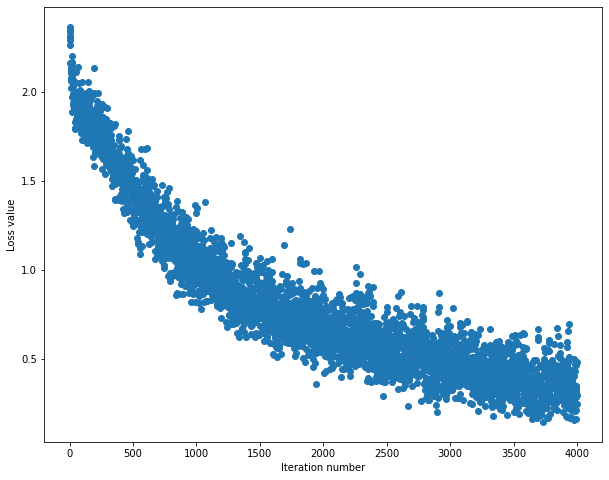

In [120]:
train_loader, val_loader, test_loader = get_data_loaders()

torch.manual_seed(0)
model = Net()
model = model.cuda()

num_epochs = 10
optimizer = optim.Adam(model.parameters(), lr=0.001) # TODO: choose an optimizer

loss_history = []
for epoch in range(num_epochs):
  val_acc = eval_acc(model, val_loader)
  
  model.train()
  
  for batch, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()
    
    optimizer.zero_grad()
    loss = model(images, labels)
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
      loss_history.append(loss.item())
      if batch == 0:
        print('Train Epoch: {:3} \t Loss: {:F} \t Val Acc: {:F}'.format(
          epoch, loss.item(), val_acc))

with torch.no_grad():
  plt.plot(loss_history, 'o')
  plt.xlabel('Iteration number')
  plt.ylabel('Loss value')
  plt.show()

## Results

In [121]:
train_acc = eval_acc(model, train_loader)
print('Training Accuracy:', train_acc)

Training Accuracy: 92.8275


In [122]:
val_acc = eval_acc(model, val_loader)
print('Validation Accuracy:', val_acc)

Validation Accuracy: 83.09


In [123]:
test_acc = eval_acc(model, test_loader)
print('Test Accuracy:', test_acc)

Test Accuracy: 83.31


The following grading cells will assign partial credit based on the validation accuracy. Please do not remove.
- ${\geq} 75\%$: 30 points
- $72\% {\sim} 75\%$: 25 points
- $69\% {\sim} 72\%$: 20 points
- $65\% {\sim} 69\%$: 15 points
- $60\% {\sim} 65\%$: 10 points
- $50\% {\sim} 60\%$: 5 points
- ${<} 50\%$: no credit

In [124]:
# Grading cell. Do not remove.

In [125]:
# Grading cell. Do not remove.

In [126]:
# Grading cell. Do not remove.

In [127]:
# Grading cell. Do not remove.

In [128]:
# Grading cell. Do not remove.

In [129]:
# Grading cell. Do not remove.